<a href="https://colab.research.google.com/github/LCaravaggio/Cosas_Sueltas/blob/main/dim_red_fabio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import pandas as pd

In [126]:
base=pd.read_csv('/content/Indices para regresion.csv', sep=';')

In [127]:
base

,fecha,INDEC,AMBA 1,AMBA 2,AMBA 3,INTERIOR 1,INTERIOR 2,INTERIOR 3,GAS 1,GAS 2,GAS 3
0,ago-22,100,100,100,100,100,100,100,100,100,100
1,sep-22,103,100,100,100,116,100,100,119,100,100
2,oct-22,112,148,100,100,126,104,111,119,100,100
3,nov-22,124,191,104,104,145,105,105,146,100,100
4,dic-22,128,191,104,104,145,105,105,146,100,100
5,ene-23,138,250,104,122,168,108,113,183,100,100
6,feb-23,144,250,104,122,178,115,120,183,100,100
7,mar-23,156,277,131,149,179,115,121,221,100,114
8,abr-23,167,551,131,149,283,120,126,221,100,114
9,may-23,209,584,163,181,298,121,128,275,136,155


In [128]:
base.columns

Index(['fecha', 'INDEC', 'AMBA 1', 'AMBA 2', 'AMBA 3', 'INTERIOR 1',
       'INTERIOR 2', 'INTERIOR 3', 'GAS 1', 'GAS 2', 'GAS 3'],
      dtype='object')

In [129]:
from sklearn.decomposition import PCA

In [130]:
columnas=['AMBA 1', 'AMBA 2', 'AMBA 3', 'INTERIOR 1', 'INTERIOR 2', 'INTERIOR 3', 'GAS 1', 'GAS 2', 'GAS 3']

In [131]:
%%capture
!pip install umap-learn
import umap.umap_ as umap

In [132]:
trans = umap.UMAP(n_neighbors=2, random_state=42).fit_transform(base[columnas])

In [133]:
base['UMPA_trans_1']=trans[:, 0]
base['UMPA_trans_2']=trans[:, 1]

In [134]:
pca = PCA(n_components=1)
trans_pca = pca.fit_transform(base[columnas])

In [135]:
base['trans_pca']=trans_pca

In [136]:
base.to_csv('indices_red.csv', sep=';')

# Random Forest

In [137]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(max_depth=3)
rf.fit(base[columnas][:-1], base['INDEC'][:-1])

RandomForestRegressor(max_depth=3)

In [138]:
base['INDEC'][-1:]

11    236
Name: INDEC, dtype: int64

In [139]:
rf.predict(base[columnas][-1:])

array([217.04])

In [140]:
red1=['UMPA_trans_1', 'UMPA_trans_2']
red2=['trans_pca']
rf=RandomForestRegressor(max_depth=7)
rf.fit(base[red1][:-1], base['INDEC'][:-1])
rf.predict(base[red1][-1:])

array([189.56])

# Regresión lineal

In [141]:
from sklearn.linear_model import LinearRegression
l=LinearRegression()

In [142]:
l.fit(base[red1][:-1], base['INDEC'][:-1])
l.predict(base[red1][-1:])

array([191.80954], dtype=float32)

In [143]:
l.fit(base[red2][:-1], base['INDEC'][:-1])
l.predict(base[red2][-1:])

array([217.30054542])

In [144]:
l.fit(base[columnas][:-1], base['INDEC'][:-1])
l.predict(base[columnas][-1:])

array([288.99119119])

# Rezago

In [145]:
base['L.INDEC']=base['INDEC'].shift()

In [146]:
rf=RandomForestRegressor(max_depth=7)
rf.fit(base[red1+['L.INDEC']][1:-1], base['INDEC'][1:-1])
rf.predict(base[red1+['L.INDEC']][-1:])

array([200.57])

In [147]:
rf=RandomForestRegressor(max_depth=12)
rf.fit(base[columnas+['L.INDEC']][1:-1], base['INDEC'][1:-1])
rf.predict(base[columnas+['L.INDEC']][-1:])

array([217.81])

In [148]:
for column in columnas:
    base[f'L.{column}'] = base[column].shift(1)

In [162]:
Lcolumnas=list(base.columns)
Lcolumnas.remove('fecha')

In [168]:
rf=RandomForestRegressor(max_depth=4)
rf.fit(base[Lcolumnas][1:-1], base['INDEC'][1:-1])
rf.predict(base[Lcolumnas][-1:])

array([218.12])

# ARMA

In [178]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(base['INDEC'], lags=2)
results = model.fit()

In [194]:
predictions=results.predict(start=2, end=len(base)-1)

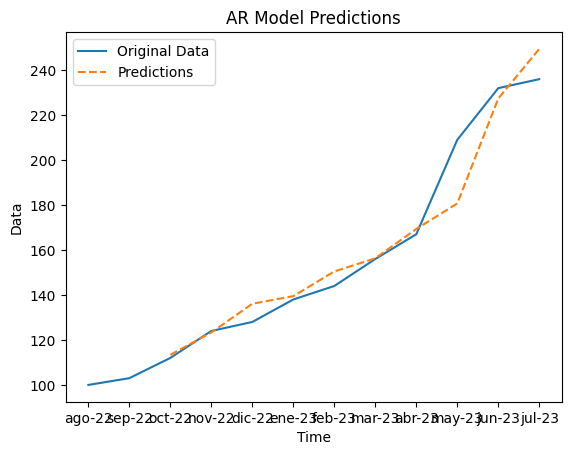

In [195]:
import matplotlib.pyplot as plt
plt.plot(base['fecha'], base['INDEC'], label='Original Data')
plt.plot(base['fecha'][2:], predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('AR Model Predictions')
plt.legend()
plt.show()

In [197]:
predictions[-1:]

11    249.451882
dtype: float64

In [176]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(base.INDEC[:-1] , order=(1, 0, 1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  INDEC   No. Observations:                   11
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -46.104
Date:                Wed, 23 Aug 2023   AIC                            100.207
Time:                        15:41:57   BIC                            101.799
Sample:                             0   HQIC                            99.204
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        160.5765     61.995      2.590      0.010      39.069     282.084
ar.L1          0.9312      0.765      1.217      0.224      -0.568       2.431
ma.L1          0.5263      1.194      0.441      0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [177]:
res.forecast()

11    229.907223
dtype: float64